# Plot analogue distance to event/BAM in different epochs 
#### From files in ./analogue_data

### Functions

In [1]:
# --- Imports ---
import os
import sys
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
import dask
from dask.distributed import Client, LocalCluster
from scipy.interpolate import griddata
import calendar
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.colors as mcolors
from scipy import ndimage
from datetime import datetime, timedelta

# --- Custom Functions ---
# sys.path.append('/home/portal/script/python/precip_Cristina/')                    # tintin
sys.path.append('/home/alice/Desktop/work/git/myISACcode/python/precip_Cristina')   # alice
sys.path.append('/home/alice/Desktop/work/git/myISACcode/python')                   # alice
import functions_analogues_PrMax as fanPM
import functions_analogues_LUCAFAMOSS as fan

### Directories

In [2]:
# # tintin
# CERRA_dir = '/work_big/users/clima/portal/CERRA-Land/'
# ERA5_dir = '/work_big/users/clima/portal/ERA5/'
# CRCM5_dir = '/work_big/users/clima/portal/CRCM5-LE/'

# alice
CERRA_dir = '/media/alice/Crucial X9/portal/data_CNR/CERRA/'
ERA5_dir = '/media/alice/Crucial X9/portal/data_CNR/ERA5/'
CRCM5_dir = '/media/alice/Crucial X9/portal/data_CNR/CRCM5-LE/'
fig_dir = '/home/alice/Desktop/CNR/ENCIRCLE/materiale_alice/figures/analogues/'
diff_dir = './analogue_data/analogue_differences/' 
pslmin_dir = './analogue_data/psl_min/'

### Variable

In [3]:
# Variable
var_analogues = 'psl'  # Variable used to find the analogues, e.g. 'psl' for sea level pressure

### Event

In [4]:
# Event
lselect = 'alertregions'  # 'Italy' or 'wide-region' or 'alert-regions'
no_node = 3
no_event = 3
event_origin = 'CRCM5-LE'  # 'ERA5' or 'CRCM5-LE'
if event_origin == 'ERA5':
    str_event = f'node{no_node}-extreme{no_event}-{lselect}'
    df_events = pd.read_excel(CERRA_dir+'events_cum_on_above99_alertregions_CERRA.xlsx', sheet_name=no_node-1)
    time_event = df_events['Time'].iloc[no_event-1] + pd.Timedelta('12h')
elif event_origin == 'CRCM5-LE':
    str_event = f'BAM-node{no_node}-extreme{no_event}-{lselect}'
    BAM_dict, BAM_index = fanPM.get_best_model_analogue_info(no_node, no_event, var_analogues)
    time_event = datetime.strptime(BAM_dict['date'][BAM_index], "%Y-%m-%d")
# Define lon-lat box of event
box_event = fanPM.box_event_PrMax_alertregions(no_node,no_event)

### Analogue selection

In [5]:
# Quantile
qtl_LE = 0.99

# Number of ensemble members
no_membs = 49
# List of members
list_membs = [name for name in os.listdir(CRCM5_dir + 'psl') if os.path.isdir(os.path.join(CRCM5_dir + 'psl', name))]
list_membs = sorted(list_membs)[:no_membs]  # Select the first 'no_membs' members
print(list_membs)

# Epochs
# list_year_ranges = [[1955, 1974], [2004, 2023], [2080, 2099]] # past [1955-1974], present [2004-2023], near-future [2030-2049], far future [2080-2099]
list_year_ranges = [[1955, 1974], [2004,2023], [2080,2099]]
no_epochs = len(list_year_ranges)

# Difference between epochs
list_diff_indices = [[0,1],[0,2],[1,2]]  # Define the indices of epochs to compare

# Months for analogue selection
month_event = time_event.month
months_sel = [month_event-1, month_event, month_event+1]
month_names = [calendar.month_abbr[month] for month in months_sel]
str_months = ''.join([name[0] for name in month_names])

['kba', 'kbb', 'kbc', 'kbd', 'kbe', 'kbf', 'kbg', 'kbh', 'kbi', 'kbj', 'kbk', 'kbl', 'kbm', 'kbn', 'kbo', 'kbp', 'kbq', 'kbr', 'kbs', 'kbt', 'kbu', 'kbv', 'kbw', 'kbx', 'kby', 'kbz', 'kca', 'kcb', 'kcc', 'kcd', 'kce', 'kcf', 'kcg', 'kch', 'kci', 'kcj', 'kck', 'kcl', 'kcm', 'kcn', 'kco', 'kcp', 'kcq', 'kcr', 'kcs', 'kct', 'kcu', 'kcw', 'kcx']


### Upload Euclidean distance of analogues from event

In [6]:
# Load ensemble data
ensemble_data = []
for i, year_range in enumerate(list_year_ranges):
    epoch_data = {}
    for memb in list_membs:
        # Construct the file path
        file_path = f'./analogue_data/times_distances_analogues-{var_analogues}_{str_event}_{int(qtl_LE*100)}pct_{year_range[0]}-{year_range[1]}_CRCM5-LE_memb-{memb}.npz'
        # Load the data from the npz file
        if not os.path.exists(file_path):
            print(f"File not found: {file_path}")
            continue
        # Load the data
        data = np.load(file_path, allow_pickle=True)
        times = data['times']
        distances = data['distances']
        epoch_data[memb] = {'times': times, 'distances': distances}
    ensemble_data.append(epoch_data)
no_analogues_LE = len(ensemble_data[0][list_membs[0]]['times'])  # Number of analogues per member

# Load ERA5 data
file_path_ERA5 = f'./analogue_data/times_distances_analogues-mslp_node{no_node}-extreme{no_event}-alertregions_{int(qtl_LE*100)}pct_2004-2023_ERA5.npz'
if not os.path.exists(file_path_ERA5):
    print(f"File not found: {file_path_ERA5}")
# Load the data
data_ERA5 = np.load(file_path_ERA5, allow_pickle=True)

In [7]:
# Distance from event
# CRCM5-LE distances
list_distances = []  # Initialize distances array for plotting
list_times = []  # Initialize times array
mean_dist = np.zeros(no_epochs)  # Initialize mean distance array for plotting
for i in range(len(list_year_ranges)):
    distances = np.zeros((no_membs, no_analogues_LE))  # Initialize distances array for plotting
    times = []  # Initialize times array for plotting
    for im, memb in enumerate(list_membs):
        # Extract distances for the current member and epoch
        distances[im] = ensemble_data[i][memb]['distances']
        times.append(ensemble_data[i][memb]['times'])
    list_distances.append(distances)  # Append distances for the current epoch
    mean_dist[i] = np.mean(distances)  # Calculate mean distance for the current epoch
    list_times.append(times)  # Append times for the current epoch

# ERA5 distances
distances_ERA5 = data_ERA5['distances']

### Plot distance from event in the different epochs

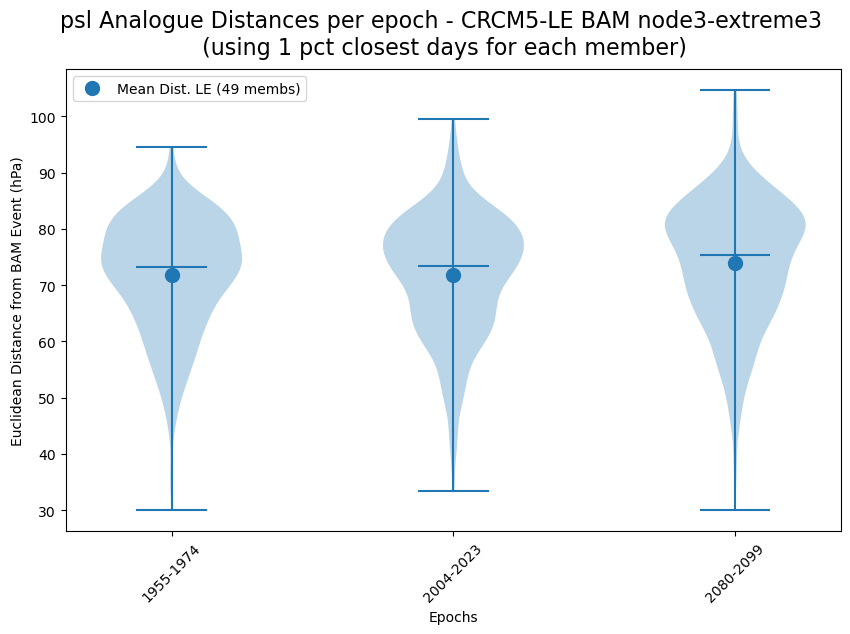

In [8]:

# Plot distance from event in the different epochs
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 6))
if event_origin == 'ERA5':
    fig.suptitle(f"{var_analogues} Analogue Distances per epoch - ERA5 event node{no_node}-extreme{no_event}\n (using {100-int(100*qtl_LE)} pct closest days for each member)", fontsize=16) 
elif event_origin == 'CRCM5-LE':
    fig.suptitle(f"{var_analogues} Analogue Distances per epoch - CRCM5-LE BAM node{no_node}-extreme{no_event}\n (using {100-int(100*qtl_LE)} pct closest days for each member)", fontsize=16)

# Violin plot setup
list_epoch_str = [f"{year_range[0]}-{year_range[1]}" for year_range in list_year_ranges]
# # Plot violin per member
# for im in range(no_membs):
#     dist_per_epoch = [dist_epoch[im] for dist_epoch in list_distances]
#     vp = ax.violinplot(dist_per_epoch, showmeans=False, showmedians=True, showextrema=True)
#     median_color = vp['cmedians'].get_color() 
# Plot violin per epoch
dist_per_epoch = [dist_epoch.flatten() for dist_epoch in list_distances]
vp = ax.violinplot(dist_per_epoch, showmeans=False, showmedians=True, showextrema=True)
median_color = vp['cmedians'].get_color() 
# Plot violin per epoch
# Plot the mean distance for the epoch
ax.plot(np.arange(1,no_epochs+1), mean_dist, marker='o', color=median_color, markersize=10, label=f'Mean Dist. LE ({no_membs} membs)', linewidth=0)

if event_origin == 'ERA5':
    # Plot ERA5 violin
    vp = ax.violinplot(distances_ERA5, positions=[2], showmeans=False, showmedians=True, showextrema=True)
    median_color = vp['cmedians'].get_color() 
    # Plot the mean distance
    ax.plot(2, distances_ERA5.mean(), marker='o', color=median_color, markersize=10, label=f'Mean Dist. ERA5', linewidth=0)

# Ticks and labels
ax.set_xticks(range(1, no_epochs+1))
ax.set_xticklabels(list_epoch_str, rotation=45)
ax.set_xlabel('Epochs')
if event_origin == 'ERA5':
    ax.set_ylabel('Euclidean Distance from ERA5 Event (hPa)')
elif event_origin == 'CRCM5-LE':
    ax.set_ylabel('Euclidean Distance from BAM Event (hPa)')
ax.legend()

# Save the figure
fig.savefig(f"{fig_dir}analogue-distances-{var_analogues}_{str_event}_{int(qtl_LE*100)}pct_CRCM5_{no_membs}membs.png", bbox_inches='tight', dpi=300)    


In [9]:
# Show distances member by member when at least one distance is below 40 and above 120
for i_ep in range(no_epochs):
    print("Epoch ",i_ep)
    for im in range(no_membs):
        if np.any(list_distances[i_ep][im] < 50) or np.any(list_distances[i_ep][im] > 120):
            print(f"Member {list_membs[im]}")
            print(f"Distances: {list_distances[i_ep][im]}")
            print(f"Timesteps: {list_times[i_ep][im]}")

Epoch  0
Member kbe
Distances: [47.53916168 56.50073242 60.07380295 61.50648117 62.35458755 62.47608185
 66.68986511 67.47798157 70.42302704 70.80345917 75.19656372 75.23410797
 77.43756866 78.78555298 79.34270477 81.02025604 81.59102631 82.40475464]
Timesteps: [cftime.DatetimeNoLeap(1965, 11, 5, 0, 0, 0, 0, has_year_zero=True)
 cftime.DatetimeNoLeap(1958, 9, 1, 0, 0, 0, 0, has_year_zero=True)
 cftime.DatetimeNoLeap(1958, 10, 16, 0, 0, 0, 0, has_year_zero=True)
 cftime.DatetimeNoLeap(1955, 9, 10, 0, 0, 0, 0, has_year_zero=True)
 cftime.DatetimeNoLeap(1962, 11, 2, 0, 0, 0, 0, has_year_zero=True)
 cftime.DatetimeNoLeap(1957, 11, 18, 0, 0, 0, 0, has_year_zero=True)
 cftime.DatetimeNoLeap(1971, 9, 27, 0, 0, 0, 0, has_year_zero=True)
 cftime.DatetimeNoLeap(1970, 9, 30, 0, 0, 0, 0, has_year_zero=True)
 cftime.DatetimeNoLeap(1959, 11, 4, 0, 0, 0, 0, has_year_zero=True)
 cftime.DatetimeNoLeap(1966, 11, 10, 0, 0, 0, 0, has_year_zero=True)
 cftime.DatetimeNoLeap(1955, 9, 22, 0, 0, 0, 0, has_year

Con ncview confronta clim Epoch 2 di kby e kbg (struttura jet ecc molto diversa)

### Upload depth of cyclone per analogue

In [10]:
# Analogue number
no_analogues_LE = 18
# File prefixes for minimum psl values
prefix_min =  f"{pslmin_dir}analogues-{var_analogues}_min-"
prefix_min_from_boxmean =  f"{pslmin_dir}analogues-{var_analogues}_min-from-boxmean-"
# Initialise lists to store minimum psl values
list_psl_min = []
list_psl_min_from_boxmean = []
for i, year_range in enumerate(list_year_ranges):
    psl_min = np.ones((no_membs, no_analogues_LE)) * np.nan
    psl_min_from_boxmean = np.ones((no_membs, no_analogues_LE)) * np.nan
    for im, memb in enumerate(list_membs):
        suffix_file = f"psl_{str_event}_{int(qtl_LE*100)}pct_{year_range[0]}-{year_range[1]}_CRCM5_{memb}.nc"
        psl_min[im] = xr.open_dataset(prefix_min+suffix_file)['psl'].values
        psl_min_from_boxmean[im] = xr.open_dataset(prefix_min_from_boxmean+suffix_file)['psl'].values
    list_psl_min.append(psl_min)
    list_psl_min_from_boxmean.append(psl_min_from_boxmean)

In [11]:
# Compute pvalues
pvalues_psl_min = []
pvalues_psl_min_from_boxmean = []
for i in range(len(list_year_ranges)-1):
    # psl_min
    arr_past = list_psl_min[i].flatten()
    arr_present = list_psl_min[i+1].flatten()
    _, p_value = fanPM.ks_stat_and_pval(arr_past, arr_present)
    pvalues_psl_min.append(p_value)
    # psl_min_from_boxmean
    arr_past = list_psl_min_from_boxmean[i].flatten()
    arr_present = list_psl_min_from_boxmean[i+1].flatten()
    _, p_value = fanPM.ks_stat_and_pval(arr_past, arr_present)
    pvalues_psl_min_from_boxmean.append(p_value)
print("P-values for psl_min between epochs:", pvalues_psl_min)
print("P-values for psl_min_from_boxmean between epochs:", pvalues_psl_min_from_boxmean)


P-values for psl_min between epochs: [np.float64(0.32471191118893367), np.float64(0.45474640738830613)]
P-values for psl_min_from_boxmean between epochs: [np.float64(0.7660711120074857), np.float64(0.11748666669455468)]


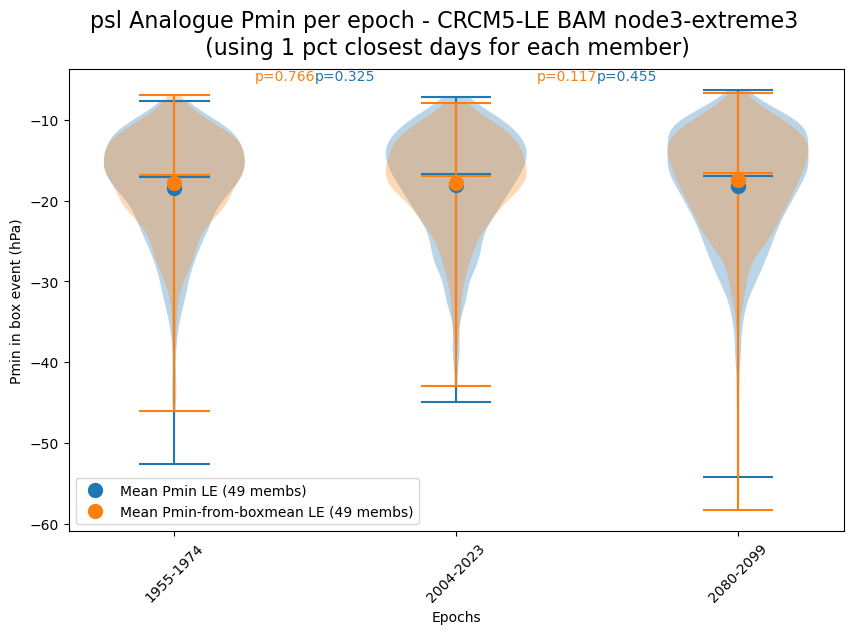

In [12]:

# Plot pressure depth in the different epochs
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 6))
if event_origin == 'ERA5':
    fig.suptitle(f"{var_analogues} Analogue Pmin per epoch - ERA5 event node{no_node}-extreme{no_event}\n (using {100-int(100*qtl_LE)} pct closest days for each member)", fontsize=16) 
elif event_origin == 'CRCM5-LE':
    fig.suptitle(f"{var_analogues} Analogue Pmin per epoch - CRCM5-LE BAM node{no_node}-extreme{no_event}\n (using {100-int(100*qtl_LE)} pct closest days for each member)", fontsize=16)

# Violin plot setup
list_epoch_str = [f"{year_range[0]}-{year_range[1]}" for year_range in list_year_ranges]
# Plot violin per epoch
pmin_per_epoch = [pmin_epoch.flatten() for pmin_epoch in list_psl_min]
pmin_from_boxmean_per_epoch = [pmin_epoch.flatten() for pmin_epoch in list_psl_min_from_boxmean]
vp1 = ax.violinplot(pmin_per_epoch, showmeans=False, showmedians=True, showextrema=True)
vp2 = ax.violinplot(pmin_from_boxmean_per_epoch, showmeans=False, showmedians=True, showextrema=True)
color1 = vp1['cmedians'].get_color() 
color2 = vp2['cmedians'].get_color()
# Plot the mean pmin for the epoch
mean_pmin = [np.nanmean(pmin_epoch) for pmin_epoch in list_psl_min]
mean_pmin_from_boxmean = [np.nanmean(pmin_epoch) for pmin_epoch in list_psl_min_from_boxmean]
ax.plot(np.arange(1,no_epochs+1), mean_pmin, marker='o', color=color1, markersize=10, label=f'Mean Pmin LE ({no_membs} membs)', linewidth=0)
ax.plot(np.arange(1,no_epochs+1), mean_pmin_from_boxmean, marker='o', color=color2, markersize=10, label=f'Mean Pmin-from-boxmean LE ({no_membs} membs)', linewidth=0)
# Plot pvalues on the plot
for i in range(len(list_year_ranges)-1):
    x_pos = (i + 1) + 0.5
    pval1 = pvalues_psl_min[i]
    pval2 = pvalues_psl_min_from_boxmean[i]
    ax.text(x_pos, ax.get_ylim()[1], f'p={pval1:.3f}', fontsize=10, color=color1, va='top', ha='left')
    ax.text(x_pos, ax.get_ylim()[1], f'p={pval2:.3f}', fontsize=10, color=color2, va='top', ha='right')

if event_origin == 'ERA5':
    pmin_ERA = xr.open_dataset(f"{pslmin_dir}analogues-mslp_min-mslp_{str_event}_{int(qtl_LE*100)}pct_2004-2023_ERA5.nc")['msl'].values
    pmin_from_boxmean_ERA = xr.open_dataset(f"{pslmin_dir}analogues-mslp_min-from-boxmean-mslp_{str_event}_{int(qtl_LE*100)}pct_2004-2023_ERA5.nc")['msl'].values
    # Plot ERA5 violin
    vp1 = ax.violinplot(pmin_ERA, positions=[2], showmeans=False, showmedians=True, showextrema=True)
    color1 = vp1['cmedians'].get_color() 
    vp2 = ax.violinplot(pmin_from_boxmean_ERA, positions=[2], showmeans=False, showmedians=True, showextrema=True)
    color2 = vp2['cmedians'].get_color()
    # Plot the mean distance
    ax.plot(2, pmin_ERA.mean(), marker='o', color=color1, markersize=10, label=f'Mean Pmin ERA5', linewidth=0)
    ax.plot(2, pmin_from_boxmean_ERA.mean(), marker='o', color=color2, markersize=10, label=f'Mean Pmin-from-boxmean ERA5', linewidth=0)

# Ticks and labels
ax.set_xticks(range(1, no_epochs+1))
ax.set_xticklabels(list_epoch_str, rotation=45)
ax.set_xlabel('Epochs')
ax.set_ylabel('Pmin in box event (hPa)')
ax.legend()

# Save the figure
fig.savefig(f"{fig_dir}analogue-pmin-{var_analogues}_{str_event}_{int(qtl_LE*100)}pct_CRCM5_{no_membs}membs.png", bbox_inches='tight', dpi=300)    
